In [17]:
import sys
sys.path.append("..")

In [19]:
import mne

from crosspy.core.methods import cplv, cplv_pairwise
from crosspy.preprocessing.seeg.support import clean_montage, drop_monopolar_channels
from crosspy.preprocessing.seeg.seeg_utils import create_reference_mask, get_electrode_distance
from crosspy.preprocessing.signal import preprocess_data_morlet

import os

import numpy as np
import glob

import matplotlib.pyplot as plt

import scipy as sp
import scipy.cluster

import sklearn
from sklearn import metrics

import re
import pandas as pd

import pickle

import tqdm

from bids import BIDSLayout

from collections import defaultdict
import cupy as cp

import itertools

from utils.ripples_utils import compute_psd_scaled

In [2]:
from matplotlib.colors import LinearSegmentedColormap
cdict1 = {'red':   ((0.0, 0.0, 0.0),
                   (0.166, 0.43, 0.43),
                   (0.33, 0.7, 0.7),
                   (0.5, 1.0, 1.0),
                   (0.66, 0.8, 0.8),
                   (1.0, 0.6, 0.6)),

         'green': ((0.0, 0.4, 0.4),
                   (0.166, 0.7, 0.7),
                   (0.33, 0.8, 0.8),
                   (0.5, 1.0, 1.0),
                   (0.66, 0.8, 0.8),
                   (1.0,0.0, 0.0)),

         'blue':  ((0.0, 0.8, 0.8),
                   (0.166, 1.0, 1.0),
                   (0.33, 1.0, 1.0),
                   (0.5, 0.4, 0.4),
                   (0.66, 0.0, 0.0),
                   (1.0, 0.0, 0.0))
        }

ripples_cmap = LinearSegmentedColormap('ripplescmap', cdict1)

In [8]:
subj_to_cluster_path = '../../../seeg_ripples/Subject_agg_cluster_labels.csv'
ez_data_path = '../../../seeg_ripples/202001_SEEG_ripple_Cohort_Contacts.csv'
convert_path = '../../../seeg_phases/data/SEEG_redux_BIDS/convert_results.csv'

In [9]:
def get_spectrum(fname, ez_mask):
    res_dict = pickle.load(open(fname, 'rb'))
    data = res_dict['cplv_spectrum']
    mask = np.logical_and(res_dict['reference_mask'].astype(bool), ez_mask)

    plv_spectrum = np.abs(data[:, mask]).mean(axis=1)
    iplv_spectrum = np.abs(np.imag(data[:, mask])).mean(axis=1)
    
    return plv_spectrum, iplv_spectrum

In [11]:
subject_to_cluster = pd.read_csv(subj_to_cluster_path).set_index('subject_number')

ez_data = pd.read_csv(ez_data_path, sep=';', header=None)
ez_grouped = ez_data.groupby(0)

df = pd.read_csv(convert_path)
df_num_idx = df.set_index('subject_number')

res_files = glob.glob('derivatives/plv_spectrum_binned/sub-??_spectrum_binned.pickle')

In [5]:
def create_ez_mask(ez_chans):
    res = np.zeros((ez_chans.shape[0], ez_chans.shape[0]), dtype=bool)
    for i in range(ez_chans.shape[0]):
        for j in range(ez_chans.shape[0]):
            res[i,j] = ez_chans[i] == 0 and ez_chans[j] == 0
    
    return res

In [6]:
frequencies = np.array(
        [
            110.        , 130.        , 150.        , 170.        ,
            190.        , 210.        , 230.        , 250.        ,
            270.        , 290.        , 310.        , 330.        ,
            350.        , 370.        , 390.        , 410.        ,
            430.        , 450.        
            ])

In [7]:
def get_value_frequency_wise(data, significant_mask):
    res = np.zeros(data.shape[:3])
    
    for idx, (arr, mask) in enumerate(zip(data, significant_mask)):
        res[idx] = arr[:, :, mask].mean(axis=2)
    
    return res

def get_value_averaged(data, significant_mask):
    return get_value_frequency_wise(data, significant_mask).mean(axis=0)

In [8]:
all_spectrums = list()
all_numbers = list()
subj_numbers = list()
subj_clusters = list()

all_spectrums_freq_wise = list()
all_numbers_freq_wise = list()

for fname in res_files:
    subj_num = re.findall('\d+', fname)[0]
    subj_code = int(subj_num)
    
    if subj_num in {'36', '57'}:
        continue
        
    cluster = subject_to_cluster.loc[subj_code]['subject_cluster'] 
    
    if cluster == 4:
        continue
    
    subj_name = df_num_idx.loc[int(subj_num)]['name']
    subj_ez = ez_grouped.get_group(subj_name).set_index(1)
    
    whole_spectrum_fname = 'derivatives/plv_spectrum/sub-{}_spectrum_with_lp.pickle'.format(subj_num)
    montage_filename = '../seeg_phases/data/SEEG_redux_BIDS/sub-{}/ses-01/ieeg/sub-{}_montage.tcsv'.format(subj_num, subj_num)
    electrodes_filename = '../seeg_phases/data/SEEG_redux_BIDS/sub-{}/ses-01/ieeg/sub-{}_electrodes.tcsv'.format(subj_num, subj_num)

    montage = pd.read_csv(montage_filename, sep='\t')
    montage = montage[montage['name'].apply(is_bipolar)]
    
    ch_names = montage['name'].values
    ez_chans = np.array([subj_ez.loc[ch_names[i]][2] != 0 for i in range(len(ch_names))])
    n_chans = len(ez_chans)
    
    ez_mask = sp.spatial.distance.pdist(ez_chans.reshape((-1,1)), metric=lambda x,y: x[0] == False and y[0] == False)
    ez_mask = sp.spatial.distance.squareform(ez_mask.astype(bool))
    
    electrodes = pd.read_csv(electrodes_filename, sep='\t')
    distance_matrix = get_electrode_distance(montage['name'].values, electrodes_filename)
    distance_mask = (distance_matrix >= 36)
    
    whole_spectrum_data = pickle.load(open(whole_spectrum_fname, 'rb'))
    res_data = pickle.load(open(fname, 'rb'))
    
    ref_mask = np.triu(whole_spectrum_data['reference_mask'].astype(bool), 1)
    
    ref_mask &= ez_mask
    ref_mask &= distance_mask
  
    surr_avg = np.abs(whole_spectrum_data['surrogate_spectrum'][32:]).mean(axis=(1,2), keepdims=True)
    
    significant = (np.abs(whole_spectrum_data['cplv_spectrum'][32:]).mean(axis=0) >= surr_avg*3.52)
    significant = significant & ref_mask
    significant = np.triu(significant, 1)
    
    ref_mask =np.repeat(ref_mask[None,...], 18, axis=0)
    
    all_spectrums.append(get_value_averaged(np.abs(res_data['cplv_spectrum']), ref_mask))
    all_numbers.append(get_value_averaged(res_data['number_of_samples'], ref_mask))    
    
    all_spectrums_freq_wise.append(get_value_frequency_wise(np.abs(res_data['cplv_spectrum']), ref_mask))
    all_numbers_freq_wise.append(get_value_frequency_wise(res_data['number_of_samples'], ref_mask))
    
#     break
    
#     surr_avg = np.abs(whole_spectrum_data['surrogate_spectrum'][32:, ref_mask]).mean()
    
#     res_data = pickle.load(open(fname, 'rb'))
    
#     significant = (np.abs(whole_spectrum_data['cplv_spectrum'][32:]).mean(axis=0) >= surr_avg*3.52)
#     significant = significant & ref_mask
    
# #     all_spectrums.append(np.abs(res_data['cplv_spectrum'][:,:,:,significant]).mean(axis=(0,3)))
# #     all_numbers.append(res_data['number_of_samples'][:,:,:,significant].mean(axis=(0,3)))

#     all_spectrums.append(np.abs(res_data['cplv_spectrum'][:,:,:,significant]).mean(axis=(0, 3)))
#     all_numbers.append(res_data['number_of_samples'][:,:,:,significant].mean(axis=(0, 3)))
    
#     all_spectrums_freq_wise.append(np.abs(res_data['cplv_spectrum'][:,:,:,significant]).mean(axis=(3)))
#     all_numbers_freq_wise.append(res_data['number_of_samples'][:,:,:,significant].mean(axis=(3)))
    
    subj_numbers.append(int(subj_num))
    subj_clusters.append(cluster)
    
#     if int(subj_num) == 1:
#         break
    
subj_clusters = np.array(subj_clusters)
subj_numbers = np.array(subj_numbers)
all_numbers = np.array(all_numbers)
all_spectrums_freq_wise = np.array(all_spectrums_freq_wise)
all_numbers_freq_wise = np.array(all_numbers_freq_wise)

/home/vladka/anaconda3/envs/sync_states/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in greater_equal


In [9]:
bins = [0, 0.54, 0.84, 1.17, 1.68]

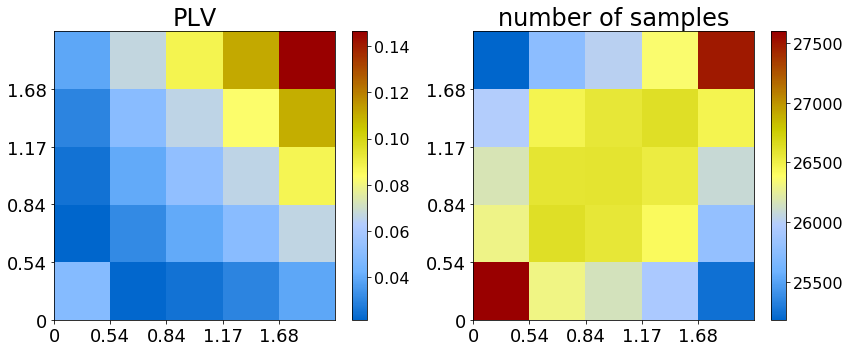

In [10]:
fig, axes = plt.subplots(figsize=(12,5), ncols=2)

imh1 = axes[0].imshow(np.mean(all_spectrums, axis=0), origin='lower', cmap=ripples_cmap, aspect='auto')
imh2 = axes[1].imshow(np.mean(all_numbers, axis=0), origin='lower', cmap=ripples_cmap, aspect='auto')

for ax in axes:
    ax.set_xticks(np.arange(5) - 0.5)
    ax.set_yticks(np.arange(5) - 0.5)
    
    ax.set_xticklabels(bins)
    ax.set_yticklabels(bins)
    
    ax.tick_params(labelsize=18)
    
cbar1 = fig.colorbar(imh1, ax=axes[0])
cbar2 = fig.colorbar(imh2, ax=axes[1])
    
cbar1.ax.tick_params(labelsize=16)
cbar2.ax.tick_params(labelsize=16)

axes[0].set_title('PLV', fontsize=24)
axes[1].set_title('number of samples', fontsize=24)

fig.tight_layout()
fig.savefig('fig_5.pdf', dpi=300)

In [12]:
def bootstrap_mean(data, N_boots=100, percentiles=(2.5, 97.5)):
    all_indices = np.arange(data.shape[0])
    
    bootstrap_samples = np.zeros((N_boots, data.shape[1]))
    
    for idx in range(N_boots):
        round_indices = np.random.choice(all_indices, size=all_indices.shape[0])
        bootstrap_samples[idx] = data[round_indices].mean(axis=0)
    
    return np.percentile(bootstrap_samples, percentiles, axis=0)

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics.regression import r2_score

def create_matrix(plv, bins):
    res = np.zeros((25, 2))
    target = plv.flatten()
    for pair_num, (i, j) in enumerate(itertools.product(range(5), range(5))):
        res[pair_num] = bins[i], bins[j]
        
    return res, target

def get_r2(plv):
    X, y = create_matrix(plv, bins)
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    
    return model.rsquared

def get_frequency_r2(plv_by_frequency):
    return [get_r2(plv) for plv in plv_by_frequency]

def get_reg_coefs(plv):
    X, y = create_matrix(plv, bins)
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    return model.params[1:].mean()

def get_frequency_coefs(plv_by_frequency):
    return [get_reg_coefs(plv) for plv in plv_by_frequency]

def get_deviation(plv):
    plv_norm = plv / plv.mean()
    plv_norm = (plv_norm - 1)*100
    return np.abs(plv_norm).mean()

def get_frequency_deviation(plv_by_frequency):
    return [get_deviation(plv) for plv in plv_by_frequency]

In [14]:
import statsmodels.api as sm

In [16]:
r2_spectrum = np.array([get_frequency_deviation(plv) for plv in all_spectrums_freq_wise])
r2_numbers = np.array([get_frequency_deviation(plv) for plv in all_numbers_freq_wise])

In [17]:
lbl_to_color = {0: ripples_cmap(0), 1: ripples_cmap(0.2), 2:ripples_cmap(0.65), 3:ripples_cmap(0.85), 4:ripples_cmap(0.99)}

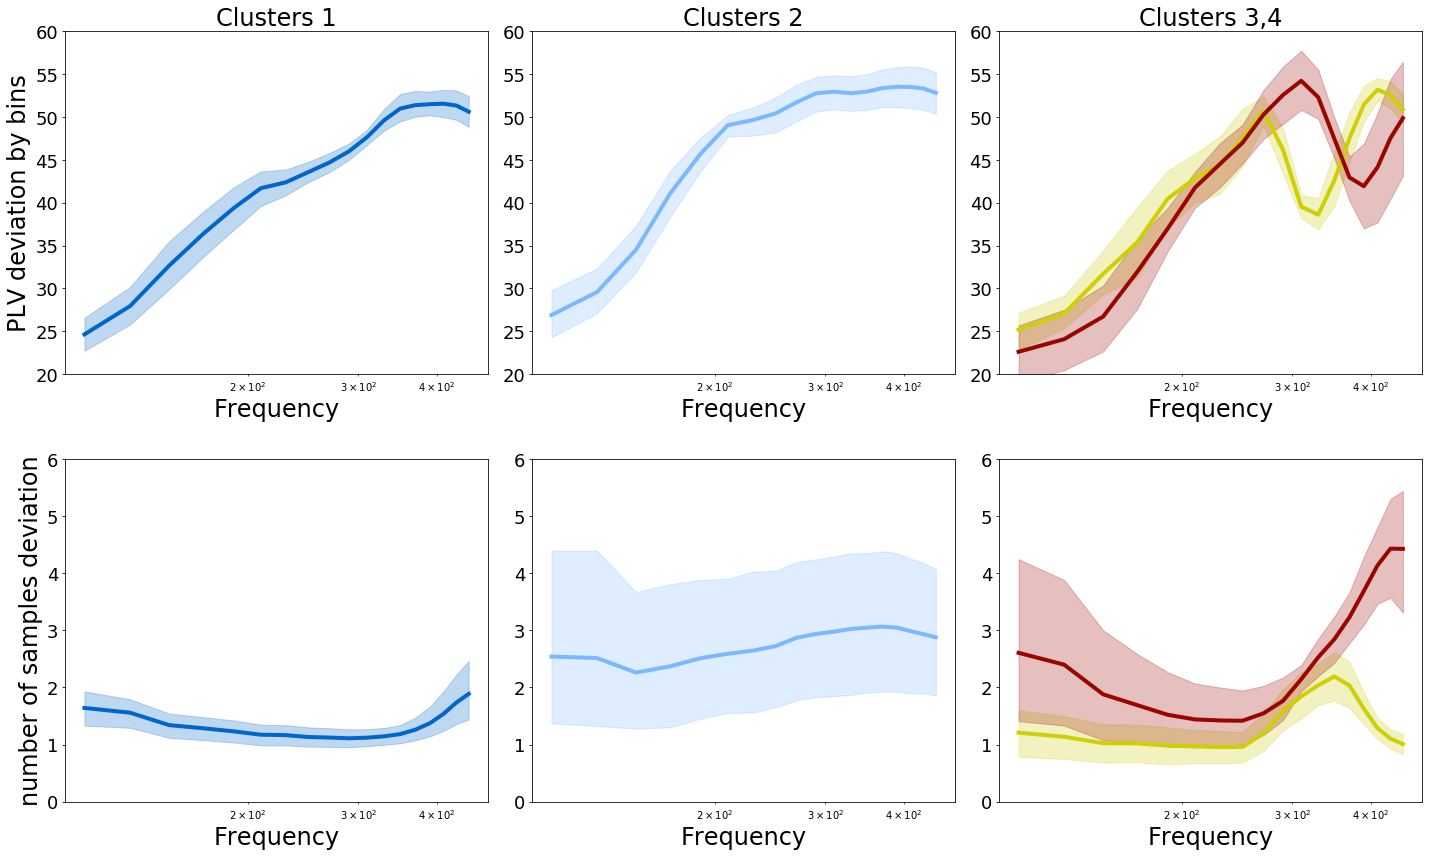

In [19]:
fig, axes = plt.subplots(figsize=(20,12), ncols=3, nrows=2)

for cluster_idx in set(subj_clusters):
    if cluster_idx in (3,5):
        ax_row = axes[:, 2]
    else:
        ax_row = axes[:, cluster_idx - 1]

    color = lbl_to_color[cluster_idx - 1]
    indices = (subj_clusters == cluster_idx)
    
    plv_std_25, plv_std_75 = bootstrap_mean(r2_spectrum[indices], N_boots=1000, percentiles=(5, 95))
    numbers_std_25, numbers_std_75 = bootstrap_mean(r2_numbers[indices], N_boots=1000, percentiles=(5,95))
    
    _ = ax_row[0].semilogx(frequencies, r2_spectrum[indices].mean(axis=0), color=color, lw=4)
    _ = ax_row[0].fill_between(frequencies, plv_std_25, plv_std_75, color=color, alpha=0.25)

    _ = ax_row[1].semilogx(frequencies, r2_numbers[indices].mean(axis=0), color=color, lw=4)
    _ = ax_row[1].fill_between(frequencies, numbers_std_25, numbers_std_75, color=color, alpha=0.25)
    
    ax_row[0].set_ylim([20, 60])
    ax_row[1].set_ylim([0, 6])
    
for idx, clusters in enumerate([[1,], [2,], [3,4]]):
    axes[0,idx].set_title('Clusters {}'.format(','.join(map(str,clusters))), fontsize=24)


axes[0,0].set_ylabel(r'PLV deviation by bins', fontsize=24)
axes[1,0].set_ylabel(r'number of samples deviation', fontsize=24)
    
    
for ax in axes.flatten():
    ax.tick_params(labelsize=18)
    ax.set_xlabel('Frequency', fontsize=24)
fig.tight_layout()
fig.savefig('fig_5_continue.pdf')